In [1]:
import sys
sys.path.append('..')

from Common.utils import *
from Common.M_matrix import M_panda
from Common.C_matrix import C_panda
from Common.G_vector import G_panda

import numpy as np

In [2]:
import matplotlib
import matplotlib.pyplot as plt

matplotlib.rc('font', **{'size': 16})
plt.rcParams.update({
  "text.usetex": True
})

In [3]:
path = '../data/trajectories/traj16_z.panda.dat' # pick one trajectory
dataset = read_data(path)
time = dataset[:,0]
dataset = dataset[np.where(time<37)]

# CMA-ES parameter retrieval

In [4]:
%%time
time = dataset[:,0]
qDot_real = dataset[:,15:15+7]
q_real = dataset[:,1:1+7]
tau_real = dataset[:,29:29+7]
u_cmd = dataset[:, 22:22+7]
G_dat = dataset[:,36:36+7]
u_G = u_cmd + G_dat

qDot_real_filtered, tau_real_filtered = ButterWorthFilter(qDot_real, tau_real, time)
u_G_filtered, _ = ButterWorthFilter(u_G, tau_real, time)

# numerical derivative to get joints acceleration.
qDDot_inf = numerical_grad_nd(qDot_real_filtered)

tau_inf_nof = calc_tau(M_panda, C_panda, G_panda, q_real, \
                                     qDot_real_filtered, qDDot_inf, dyna_func='cma')

CPU times: user 1min 53s, sys: 12.9 ms, total: 1min 53s
Wall time: 1min 53s


In [5]:
MAE = np.abs(tau_real_filtered-tau_inf_nof).sum() / len(tau_inf_nof)
print("MAE for CMA-ES: {:0.4f}".format(MAE))
# mu = 1, MAE = 1.9906
# mu = 100, MAE = 1.9906

MAE for CMA-ES: 1.9095


In [6]:
%%time
tau_inf_nof_2 = calc_tau(M_panda, C_panda, G_panda, q_real, \
                                     qDot_real_filtered, qDDot_inf)

CPU times: user 1min 56s, sys: 4.21 ms, total: 1min 56s
Wall time: 1min 56s


In [7]:
MAE = np.abs(tau_real_filtered-tau_inf_nof_2).sum() / len(tau_inf_nof)
print("MAE for orginal algorithm: {:0.4f}".format(MAE))

MAE for orginal algorithm: 3.3961


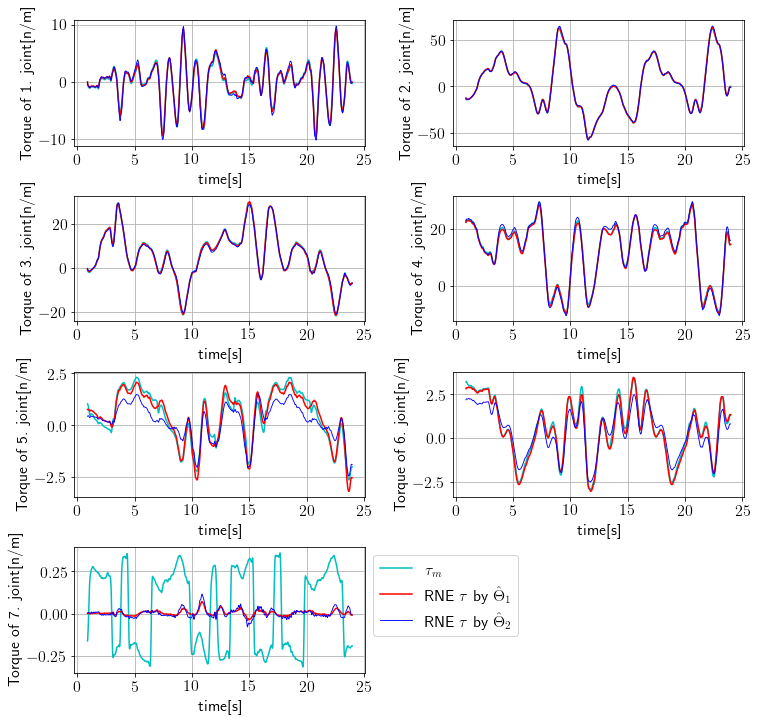

In [8]:
plt.figure(figsize=[12,12])
for channel in range(7):
    plt.subplot(4,2,channel+1,xlabel="time[s]", ylabel="Torque of {}. joint[n/m]".format(channel+1))
    plt.plot(time, tau_real_filtered[:,channel],'-c', label=r"$\tau_m$")
    plt.plot(time, tau_inf_nof[:,channel],'-r', label=r"RNE $\tau$ by $\hat{\Theta}_{1}$")
    plt.plot(time, tau_inf_nof_2[:,channel],'-b', label=r"RNE $\tau$ by $\hat{\Theta}_{2}$", linewidth=0.9)
    plt.grid()
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=.3, hspace=.4)
plt.legend(bbox_to_anchor=(1, 1), fancybox=True)
plt.savefig("/home/jiayun/Desktop/PR_algo_2.jpg", dpi=200)
plt.show()

### load the residual and friction prediction

In [9]:
fric_pred = np.load('../Common/friction_compensation.npy')
res_pred = np.load('../Common/residual_compensation.npy')

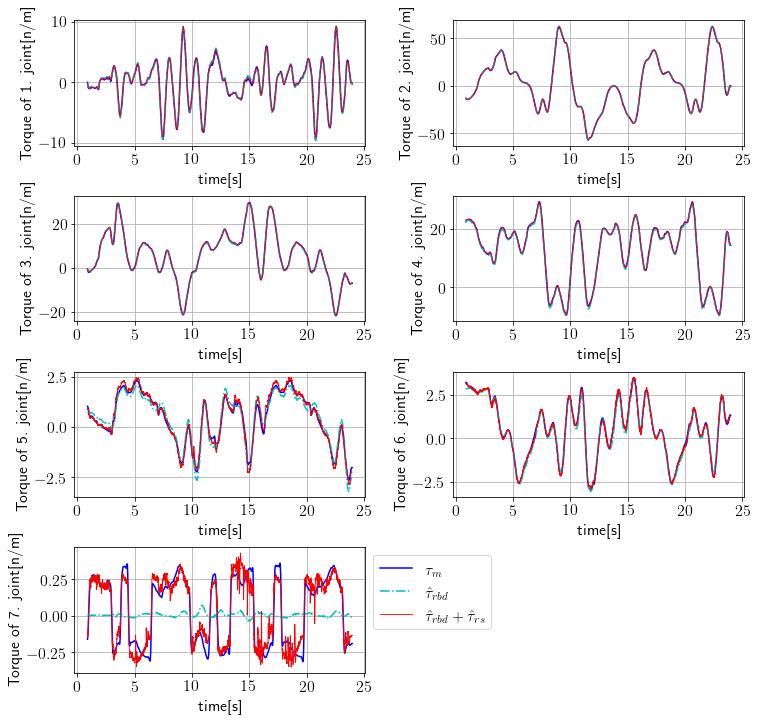

In [14]:
plt.figure(figsize=[12,12])
for channel in range(7):
    plt.subplot(4,2,channel+1,xlabel="time[s]", ylabel="Torque of {}. joint[n/m]".format(channel+1))
    plt.plot(time, tau_real_filtered[:,channel],'-b', label=r"$\tau_m$")
    plt.plot(time, tau_inf_nof[:,channel],'-.c', label=r"$\hat{\tau}_{rbd}$")
    plt.plot(time, tau_inf_nof[:,channel]+res_pred[:, channel], '-r', label=r"$\hat{\tau}_{rbd} + \hat{\tau}_{rs}$",
             linewidth=0.85)
    plt.grid()
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=.3, hspace=.4)
plt.legend(bbox_to_anchor=(1, 1), fancybox=True)
plt.savefig("/home/jiayun/Desktop/final_2.jpg", dpi=200)
plt.show()

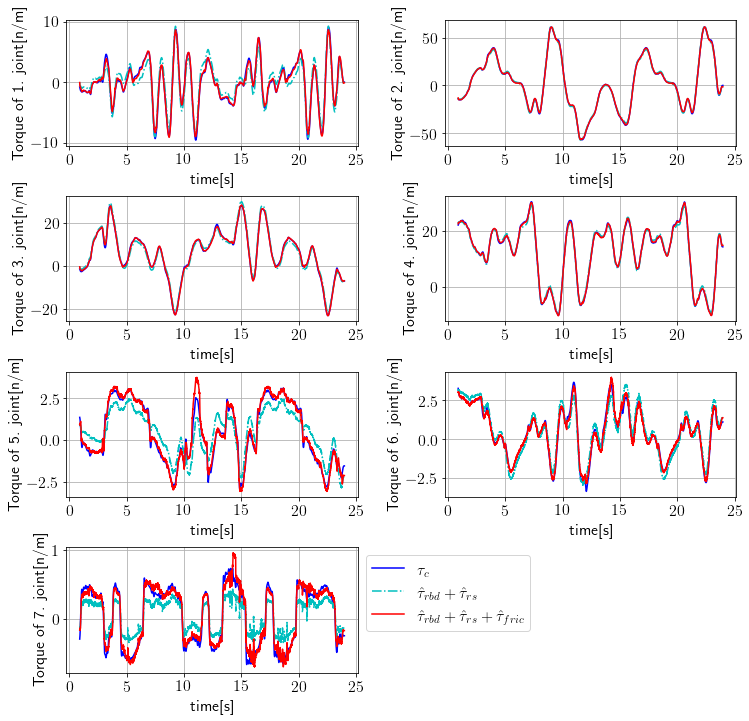

In [16]:
plt.figure(figsize=[12,12])
for channel in range(7):
    plt.subplot(4,2,channel+1,xlabel="time[s]", ylabel="Torque of {}. joint[n/m]".format(channel+1))
    plt.plot(time, u_G_filtered[:,channel],'-b', label=r"$\tau_c$")
    plt.plot(time, tau_inf_nof[:,channel]+res_pred[:, channel],'-.c', 
             label=r"$\hat{\tau}_{rbd} + \hat{\tau}_{rs}$")
    plt.plot(time, tau_inf_nof[:,channel]+fric_pred[:, channel]+res_pred[:, channel],'-r', 
             label=r"$\hat{\tau}_{rbd} + \hat{\tau}_{rs} + \hat{\tau}_{fric}$")
    plt.grid()
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=.3, hspace=.4)
plt.legend(bbox_to_anchor=(1, 1), fancybox=True)
plt.savefig("/home/jiayun/Desktop/final_1.jpg", dpi=200)
plt.show()